In [3]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from global_land_mask import globe
import scipy.stats as stats
import os

In [4]:
# Load datasets
dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02CRI.nc")
# catalog = pd.read_csv('eq_200204_202102.csv')
# catalog["time"] = catalog["time"].astype("datetime64")
catalog = pd.read_csv(dataset_path + 'ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64")

In [5]:
def get_mass(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["lwe_thickness"]
    return mass_change.data
  
catalog['dmass'] = catalog.apply(lambda row: get_mass(row), axis=1)

In [6]:
# catalog['on_land'] = globe.is_land(catalog.latitude, catalog.longitude)

In [7]:
def plot_hist(all_time_periods, earthquake_only, ax1, ax2, title1, title2):
    
    # Cumulative histogram

    bins = np.linspace(-80,80,41)
    ax1.hist(earthquake_only, bins, density = True, cumulative=True, histtype='step',
            label='Time periods with an earthquake',linewidth=1.5)
    ax1.hist(all_time_periods, bins, density = True, cumulative=True,histtype='step',
            label='All time periods',linewidth=1.5)
    ax1.set_ylim((-0.1,1.3))
    ax1.legend()
    ax1.set_xlabel('Surface load (cm water equiv.)', fontsize = 17)
    ax1.set_ylabel("Cumulative probability", fontsize = 17)
    ax1.set_title(title1)
    
    # Non-cumulative histogram

    ax2.hist(earthquake_only, bins, density = True, cumulative=False, histtype='step',
            label='Time periods with an earthquake',linewidth=1.5)
    ax2.hist(all_time_periods, bins, density = True, cumulative=False,histtype='step',
            label='All time periods',linewidth=1.5)
    yl = ax2.get_ylim()
    ax2.set_ylim((-0.01,1.4*yl[1]))
    ax2.set_xlim((-40,60))
    ax2.legend()
    ax2.set_xlabel('Surface load (cm water equiv.)', fontsize = 17)
    ax2.set_ylabel("Probability", fontsize = 17)
    ax2.set_title(title2)

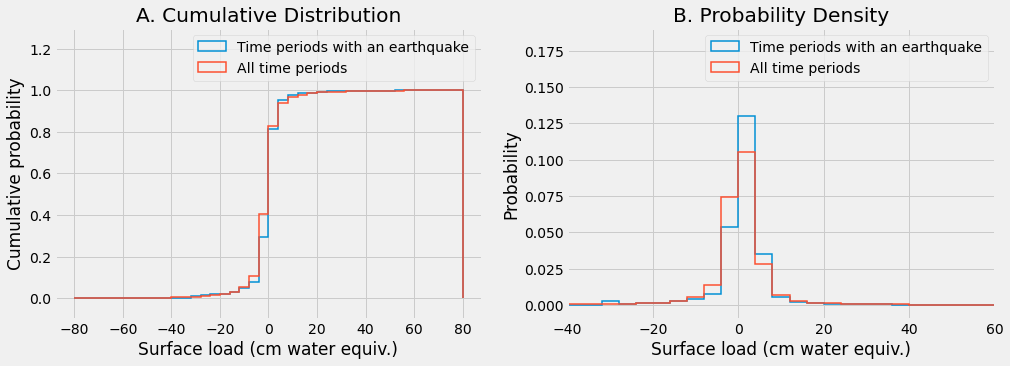

In [81]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
plt.style.use('fivethirtyeight')

plot_hist(np.array(ds['lwe_thickness'].data.flatten()), np.array(catalog.dmass), ax1, ax2, 
              'A. Cumulative Distribution', 'B. Probability Density')

In [7]:
def calc_stats(a,b):
    '''
    Calculate stats for the distributions a and b
    a: distribution during earthquakes
    b: distribution over all time periods
    '''
    
    result = {} # this creates a dictionary
    
    result['cvm'] = stats.cramervonmises_2samp(a, b, method='auto')
    result['ks'] = stats.ks_2samp(a, b)
    result['median_all'] = np.median(b)
    result['median_eq'] = np.median(a)
    result['mean_all'] = np.mean(b)
    result['mean_eq'] = np.mean(a)
    result['mean_all_minus_mean_eq'] = np.mean(b)-np.mean(a)
    result['median_all_minus_median_eq'] = np.median(b)-np.median(a)
    
    return result

## Using Bayes' Theorem:

In [9]:
# Relative probability of earthquake given loading

def plot_rel_hist(all_time_periods, earthquake_only, ax, title):
    
    bins = np.linspace(-80,80,41)
    LgE = np.histogram(earthquake_only, bins=bins, density = True)[0]
    L   = np.histogram(all_time_periods,bins=bins, density = True)[0]

    wid = np.mean(np.diff(bins))
    ax.bar(bins[:-1]+wid/2,LgE/L,width=wid)

    ax.plot([-80,80],[1, 1],'--r')
    ax.text(-20, 1.5,'P=P(E)',color='r',fontsize=20)
    ax.set_xlabel('Surface Load (cm water equiv.)',fontsize = 17)
    ax.set_ylabel('Relative Probability',fontsize = 17)
    ax.set_title(title, fontsize = 17)
    return fig,ax


(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Relative Probability Of Earthquake'}, xlabel='Surface Load (cm water equiv.)', ylabel='Relative Probability'>)

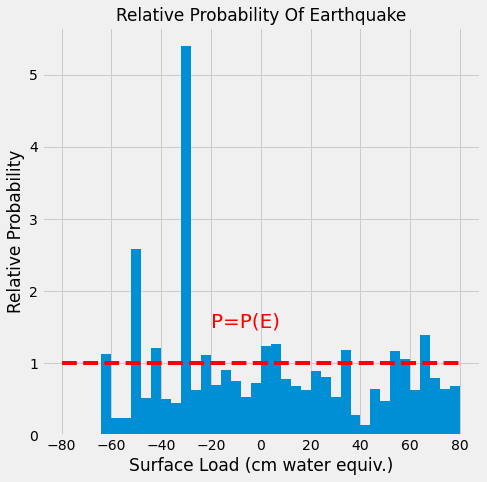

In [151]:
fig,ax = plt.subplots(figsize=(7,7))
plt.style.use('fivethirtyeight')
plot_rel_hist(np.array(ds['lwe_thickness'].data.flatten()), np.array(catalog.dmass), ax, 
              "Relative Probability Of Earthquake")

In [12]:
# calc_stats(np.array(catalog.dmass),np.array(ds['lwe_thickness'].data.flatten()))

## Correlation between reconstructed D values and seismic activity


In [14]:
# Loading D values from pca grace

D_eq_values = []
for filenumber in np.arange(1,7):
    filename = os.path.join('/data/fast1/surface-load/pca/','D_eq_%d.csv'%filenumber)
    D_eq_values.append( np.loadtxt(filename, delimiter=',') )
    # asumes filenames like 'D_eq_values_1.csv', 'D_eq_values_2.csv', and so on

D_values = []
for filenumber in np.arange(1,7):
    filename = os.path.join('/data/fast1/surface-load/pca/','D_%d.csv'%filenumber)
    D_values.append( np.loadtxt(filename, delimiter=',') )

In [15]:
len(D_values[0])

210894

In [16]:
# stats = []

# for i in range(6):
#     stats.append(calc_stats(D_eq_values[i], D_values[i]))

# pd.DataFrame(stats)


## Correlation between detrended D values and seismic activity

In [17]:
# Loading detrended data

D_detrend_eq_values = []
for filenumber in np.arange(1,7):
    D_detrend_eq_values.append( np.loadtxt('D_detrend_eq_%d.csv'%filenumber, delimiter=',') )

D_detrend_values = []
for filenumber in np.arange(1,7):
    D_detrend_values.append( np.loadtxt('D_detrend_%d.csv'%filenumber, delimiter=',') )

In [18]:
D_detrend_values[1]

array([[-0.24389828, -0.24098377,  0.13128741, ...,  0.10751991,
        -0.01900568, -0.09380543],
       [-0.24389828, -0.24098377,  0.13128741, ...,  0.10751991,
        -0.01900568, -0.09380543],
       [-0.24389828, -0.24098377,  0.13128741, ...,  0.10751991,
        -0.01900568, -0.09380543],
       ...,
       [-1.65856852, -1.63874914,  0.89278681, ...,  0.73116197,
        -0.12924334, -0.63790006],
       [-1.65856852, -1.63874914,  0.89278681, ...,  0.73116197,
        -0.12924334, -0.63790006],
       [-1.65856852, -1.63874914,  0.89278681, ...,  0.73116197,
        -0.12924334, -0.63790006]])

In [19]:
# stats_detrend = []

# for i in range(6):
#     stats_detrend.append(calc_stats(D_detrend_eq_values[i], D_detrend_values[i]))

## Maps 

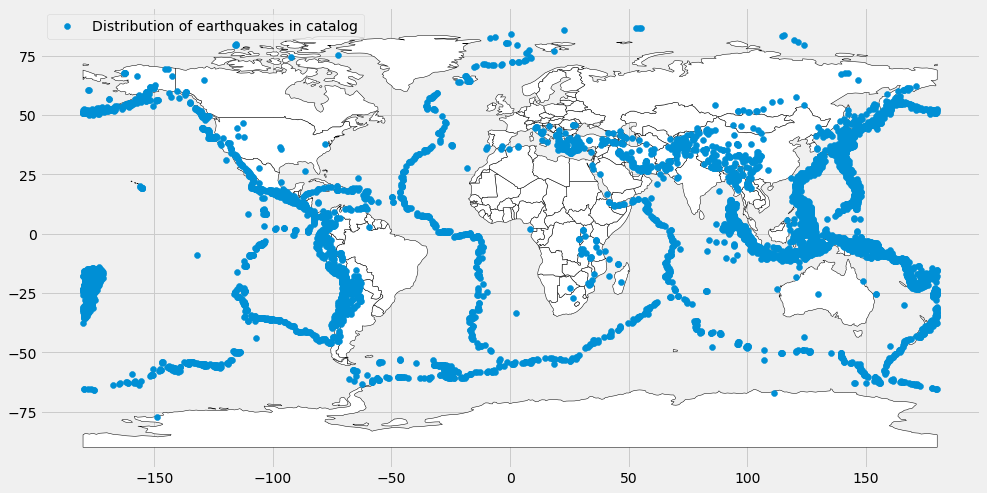

In [20]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(catalog.longitude, catalog.latitude))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = world.plot(color='white', edgecolor='black', figsize=(8,6))
ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
gdf.plot(ax=ax, label='Distribution of earthquakes in catalog')
leg = ax.legend()

# gdi = gpd.GeoDataFrame(df_ind, geometry=gpd.points_from_xy(df_ind.longitude, df_ind.latitude))
# gdi.plot(ax=ax, markersize = 5)

# plt.show()

In [21]:
def plot_map(eq_load1, bigmass1, label1):

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black', figsize=(15,10))

    # first PC
    df_bigmass = bigmass1
    gdf = gpd.GeoDataFrame(df_bigmass,
                       geometry=gpd.points_from_xy(df_bigmass.longitude, df_bigmass.latitude))
    gdf.plot(ax=ax, label=label1)

    leg = ax.legend()
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
    plt.show()

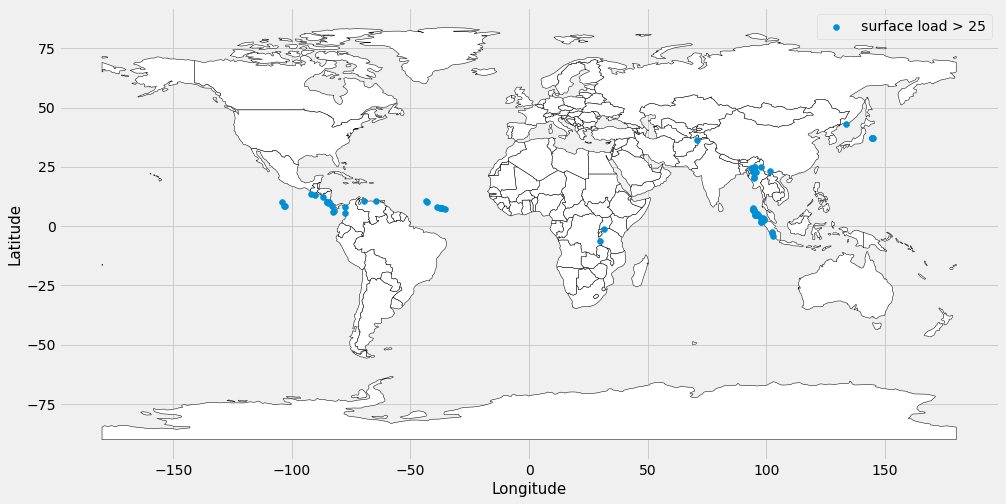

In [22]:
plot_map(catalog['dmass'], catalog[catalog['dmass'] > 25],"surface load > 25")

In [23]:
catalog[catalog['dmass'] > 25]

,target_id,latitude,longitude,time,magnitude,geometry,mu,P_triggered,P_background,dmass
91,95,-4.3366,102.6881,2021-01-06 17:28:35.120,5.5,POINT (-4.3366 102.6881),8.774521e-11,0.997886,0.002114,25.832691802281058
173,177,10.6312,-43.5286,2020-10-30 08:38:41.148,5.9,POINT (10.6312 -43.5286),8.774521e-11,0.988361,0.011639,37.32741995455441
209,213,24.6661,93.4997,2020-10-10 17:38:00.765,5.5,POINT (24.6661 93.4997),8.774521e-11,0.995914,0.004086,37.30820618149779
241,245,7.7831,-37.0931,2020-09-17 03:00:18.282,5.7,POINT (7.7831 -37.0931),8.774521e-11,0.999969,0.000031,26.465385880040483
259,263,7.6829,-37.1544,2020-09-06 06:51:18.470,6.7,POINT (7.6829 -37.1544),8.774521e-11,0.998113,0.001887,26.465385880040483
...,...,...,...,...,...,...,...,...,...,...
7640,7644,8.0930,-38.7050,2008-09-10 13:08:14.690,6.6,POINT (8.093 -38.705),8.774521e-11,0.988624,0.011376,26.49683618292534
7680,7684,25.0390,97.6970,2008-08-21 12:24:30.930,6.0,POINT (25.039 97.697),8.774521e-11,0.616151,0.383849,27.546351355045417
8651,8655,36.4510,70.6880,2007-04-03 03:35:07.280,6.2,POINT (36.451 70.688),8.774521e-11,0.999669,0.000331,31.263535482257517
8691,8695,-6.2680,29.6730,2007-03-28 21:17:10.650,5.8,POINT (-6.268 29.673),8.774521e-11,0.999558,0.000442,30.944028240669553


### Plotting all PCs on the same map

In [56]:
def plot_same_map(eq_load1, eq_load2, bounds1, bounds2, label1, label2):

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black', figsize=(15,10))

    # first PC
    df_bigmass = bounds1
    gdf = gpd.GeoDataFrame(df_bigmass,
                       geometry=gpd.points_from_xy(df_bigmass.longitude, df_bigmass.latitude))
    gdf.plot(ax=ax, label=label1)


    # second pc
    df_bigmass = bounds2
    gdf = gpd.GeoDataFrame(df_bigmass,
                       geometry=gpd.points_from_xy(df_bigmass.longitude, df_bigmass.latitude))
    gdf.plot(ax=ax, label=label2)


    leg = ax.legend()
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
    plt.show()

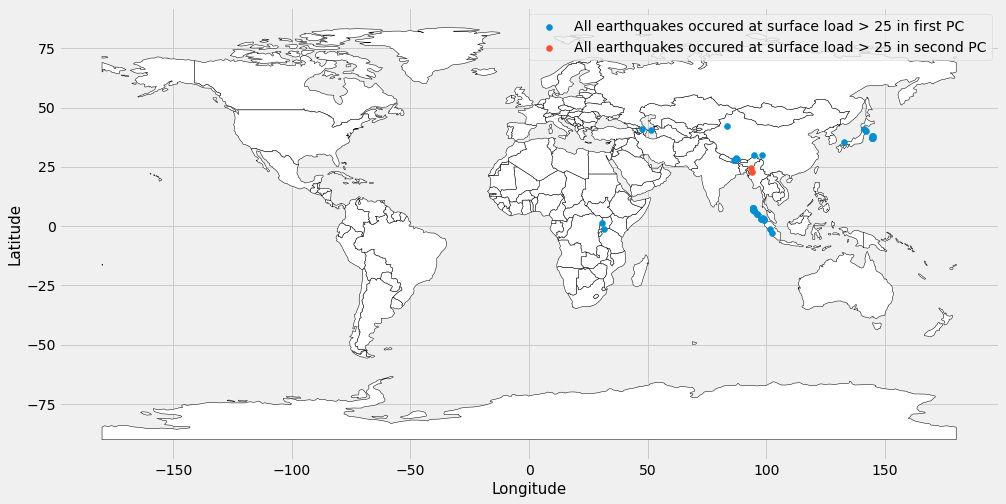

In [57]:
plot_same_map(D_eq_values[0],D_eq_values[1], 
              catalog[np.abs(D_eq_values[0]) > 25],
              catalog[np.abs(D_eq_values[1]) > 25], 
              'All earthquakes occured at surface load > 25 in first PC',
              'All earthquakes occured at surface load > 25 in second PC')

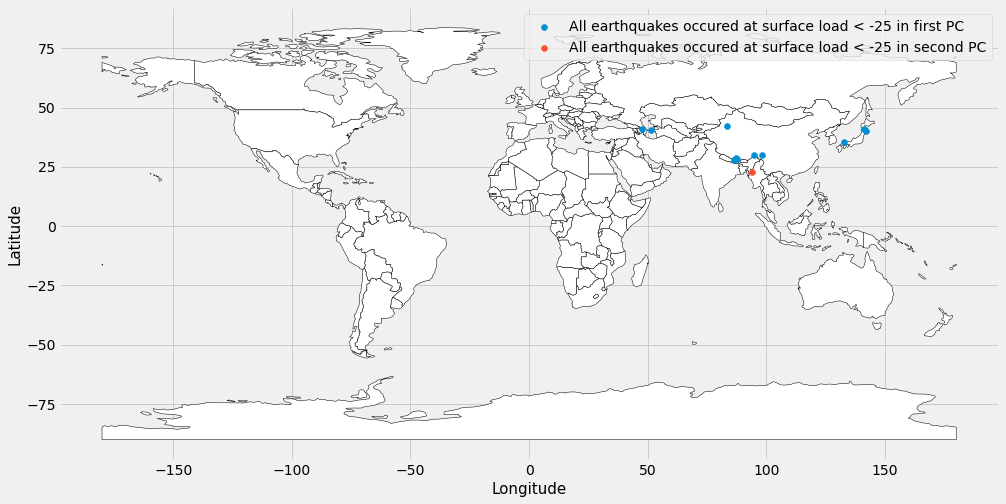

In [26]:
plot_same_map(D_eq_values[0],D_eq_values[1],
               catalog[D_eq_values[0] < -25],
               catalog[D_eq_values[1] < -25],
               'All earthquakes occured at surface load < -25 in first PC',
               'All earthquakes occured at surface load < -25 in second PC')

### Plotting all pcs on the same map for detrended data

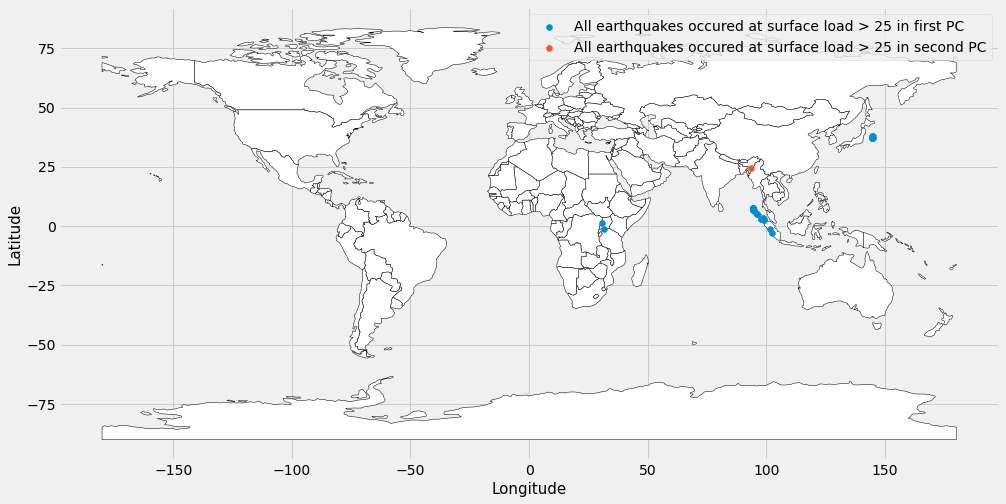

In [53]:
plot_same_map(D_detrend_eq_values[0],D_detrend_eq_values[1],
               catalog[D_detrend_eq_values[0] > 25],
               catalog[D_detrend_eq_values[1] > 25],
              'All earthquakes occured at surface load > 25 in first PC',
              'All earthquakes occured at surface load > 25 in second PC')

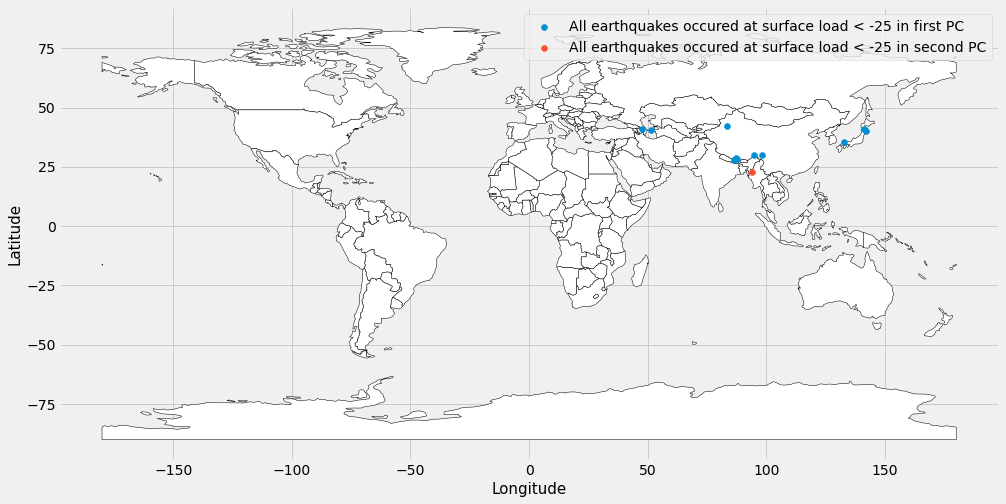

In [28]:
plot_same_map(D_detrend_eq_values[0],D_detrend_eq_values[1],
               catalog[D_detrend_eq_values[0] < -25],
               catalog[D_detrend_eq_values[1] < -25],
               'All earthquakes occured at surface load < -25 in first PC',
               'All earthquakes occured at surface load < -25 in second PC')

## Map of earthquakes with relative probability > 2

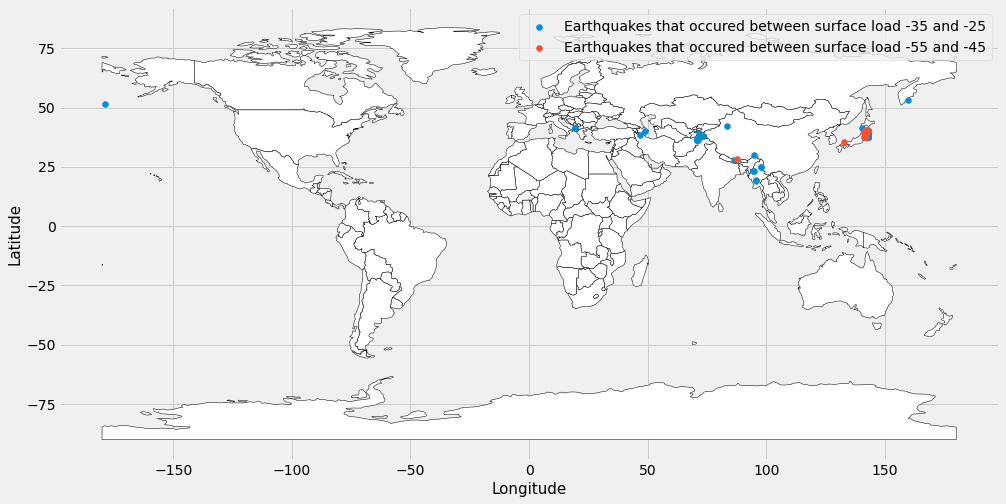

In [29]:
plot_same_map(catalog['dmass'],catalog['dmass'],
             catalog[(-35 < catalog['dmass']) & (catalog['dmass'] < -25)],
             catalog[(-55 < catalog['dmass']) & (catalog['dmass'] < -45)],
             'Earthquakes that occured between surface load -35 and -25',
             'Earthquakes that occured between surface load -55 and -45')

## Figures for poster

In [30]:
def set_of_figures(all_time, earthquake_only):

    fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,5))

    plt.style.use('fivethirtyeight')
    plot_hist(all_time, earthquake_only, ax1, ax2, 
              'A. Cumulative Distribution', 'B. Probability Density')

    plot_rel_hist(all_time, earthquake_only, ax3, 
                  'C. Relative probability of earthquake')

    fig.tight_layout()

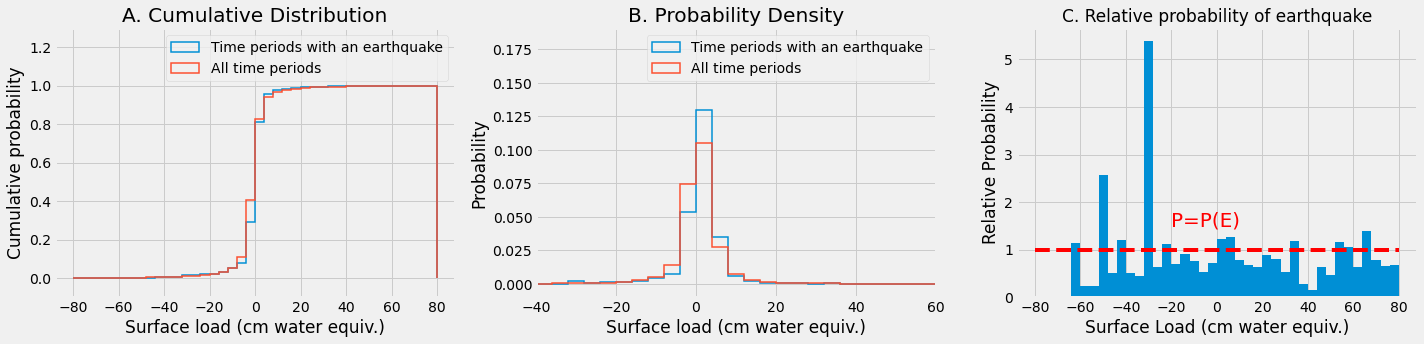

In [31]:
# Main result

set_of_figures(ds['lwe_thickness'].data.flatten(),catalog['dmass'])

<ipython-input-9-09c3742a08c2>:10: RuntimeWarning: invalid value encountered in true_divide
  ax.bar(bins[:-1]+wid/2,LgE/L,width=wid)


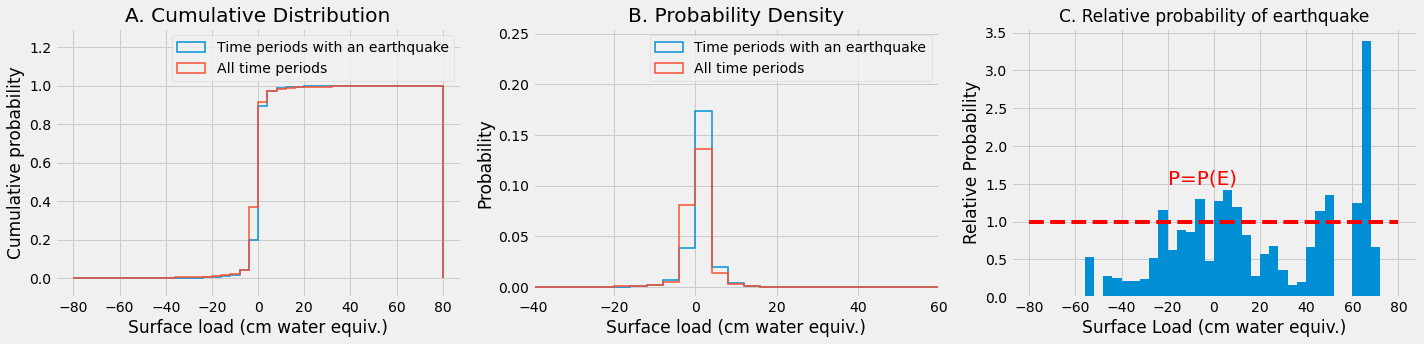

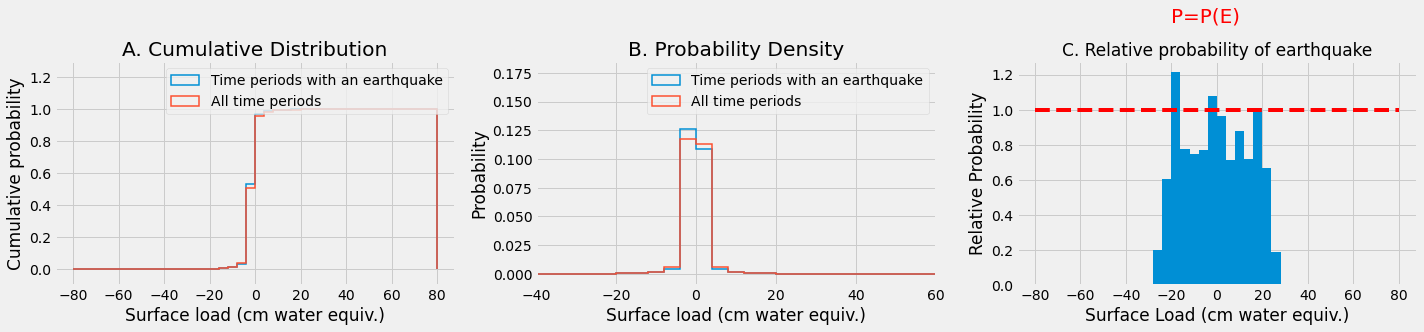

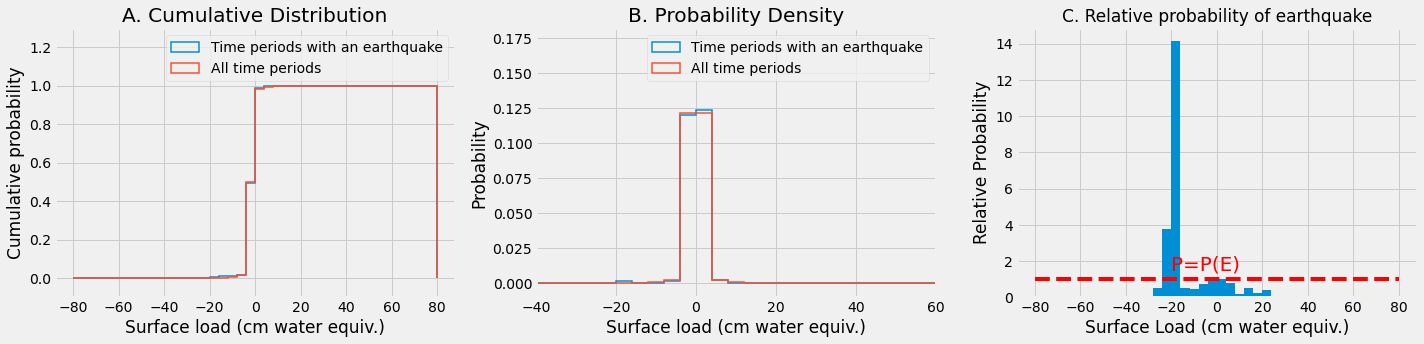

In [32]:
# Correlation using PCs

for i in range(3):
    set_of_figures(D_values[i].flatten(), D_eq_values[i])

<ipython-input-9-09c3742a08c2>:10: RuntimeWarning: invalid value encountered in true_divide
  ax.bar(bins[:-1]+wid/2,LgE/L,width=wid)


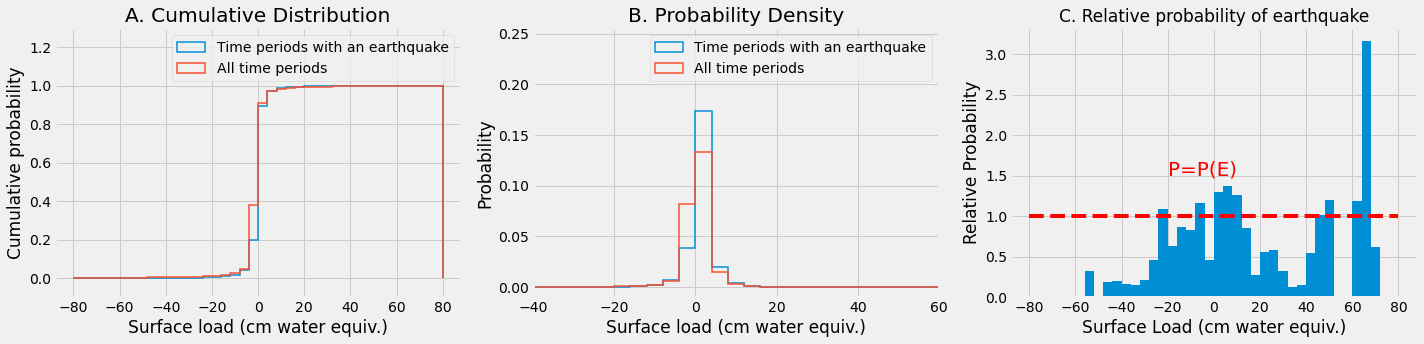

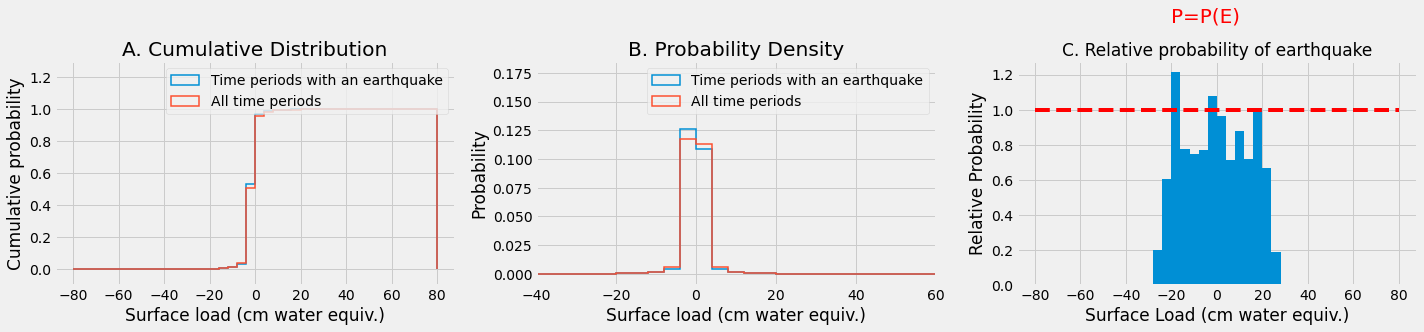

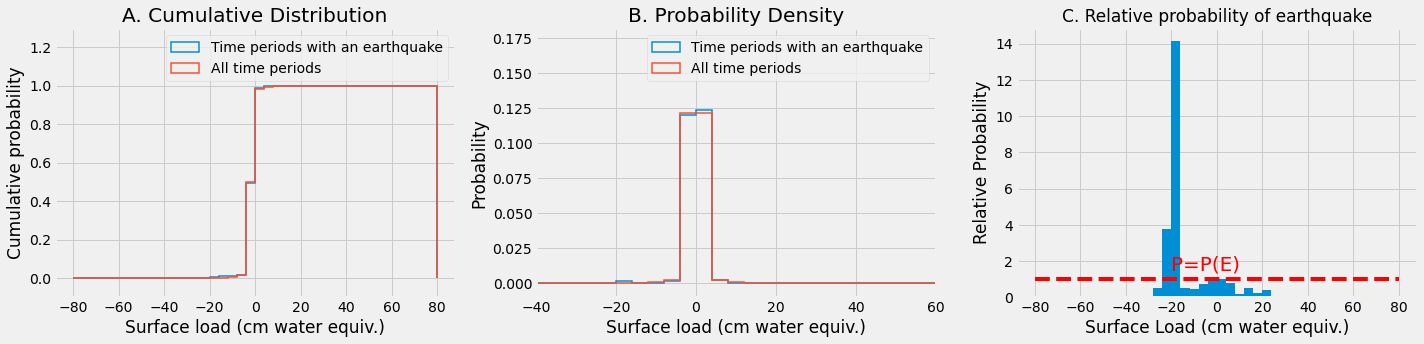

In [33]:
# Detrended PCs

for i in range(3):
    set_of_figures(D_detrend_values[i].flatten(), D_detrend_eq_values[i])

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Relative Probability Of Earthquake'}, xlabel='Surface Load (cm water equiv.)', ylabel='Relative Probability'>)

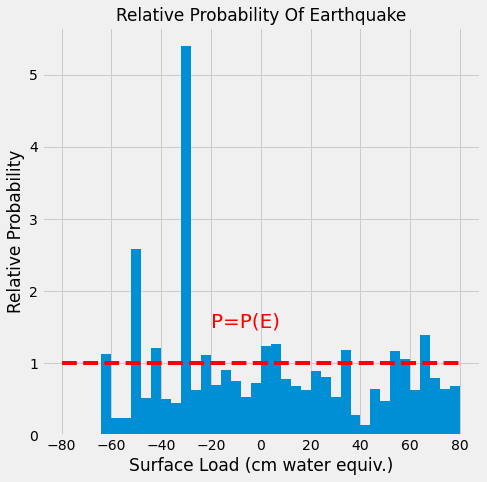

In [34]:
fig,ax = plt.subplots(figsize=(7,7))
plt.style.use('fivethirtyeight')
plot_rel_hist(np.array(ds['lwe_thickness'].data.flatten()), np.array(catalog.dmass), ax, 
              "Relative Probability Of Earthquake")

## Mapping earthquakes with high conditional probability

In [42]:
# # 1. Find which bin the load is in

# surface_load = np.array(catalog.dmass) # --- loading values during an earthquake
# bins = np.linspace(-80,80,41)
# which_bin = np.digitize(surface_load,bins)

# # 2. Find height of bin

# LgE = np.histogram(earthquake_only, bins=bins, density = True)[0]
# L   = np.histogram(all_time_periods,bins=bins, density = True)[0]
# height = LgE/L

# # 3. Find loading with conditional probability > 2

# high_cond_prob = height[height > 2]

# # What is the height of the bin with high conditional probability?

# indices = np.where(np.in1d(height, high_cond_prob))[0]

# for i in range(len(indices)):
#     print(height[indices[i]])
    
# # Find height of bin from which_bin --- doesn't work!

# Bin_Heights = []

# for i in range(2000):
#     Bin_Heights.append(height[which_bin[i]])

In [43]:
def high_cond_prob(earthquake_only, all_time_periods, bins):
    
    LgE = np.histogram(earthquake_only, bins=bins, density = True)[0]
    L   = np.histogram(all_time_periods,bins=bins, density = True)[0]
    
    which_bin = np.digitize(earthquake_only,bins)
    height = LgE/L
    high_cond_prob = height[height > 2]
    
    indices = np.where(np.in1d(height, high_cond_prob))[0]
     
    print("Bin number =")
    print(indices)
    
    print("Surface load = ")
    for i in range(len(indices)):
        print("Between")
        print(bins[indices[i-1]])
        print("and")
        print(bins[indices[i-1]+1])
        
    print("Corresponding bin height = ")
    for i in range(len(indices)):
        print(height[indices[i-1]])

In [44]:
# np.where(height > 2)

In [45]:
high_cond_prob(np.array(catalog.dmass),np.array(ds['lwe_thickness'].data.flatten()),bins)

Bin number =
[ 7 12]
Surface load = 
Between
-32.0
and
-28.0
Between
-52.0
and
-48.0
Corresponding bin height = 
5.3912656782524495
2.5789768251023255


0.9460659898477157

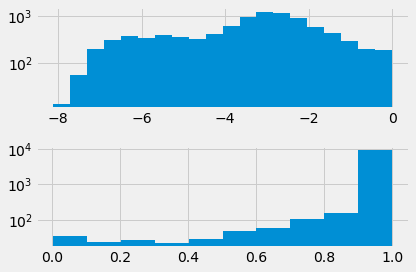

In [46]:
plt.subplots()
plt.subplot(2,1,1)
plt.hist(np.log10(1-catalog['P_triggered'].to_numpy()),20)
plt.yscale('log')

plt.subplot(2,1,2)
plt.hist(catalog['P_triggered'].to_numpy())
plt.yscale('log')

plt.tight_layout()

len(np.where(catalog['P_triggered']>.9)[0])/len(catalog)


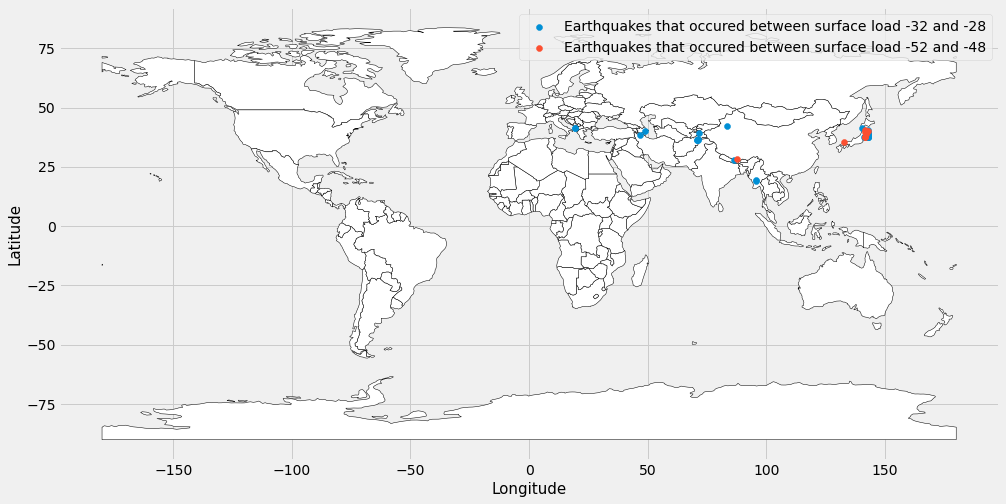

In [47]:
plot_same_map(catalog['dmass'],catalog['dmass'],
             catalog[(-32 < catalog['dmass']) & (catalog['dmass'] < -28)],
             catalog[(-52 < catalog['dmass']) & (catalog['dmass'] < -48)],
             'Earthquakes that occured between surface load -32 and -28',
             'Earthquakes that occured between surface load -52 and -48')

In [48]:
high_cond_prob(D_eq_values[0],D_values[0],bins)

Bin number =
[36]
Surface load = 
Between
64.0
and
68.0
Corresponding bin height = 
3.3910386439639204


In [ ]:
bins = np.linspace(-80,80,41)
LgE = np.histogram(np.array(catalog.dmass), bins=bins, density = True)[0]
L   = np.histogram(np.array(ds['lwe_thickness'].data.flatten()),bins=bins, density = True)[0]

wid = np.mean(np.diff(bins))
plt.bar(bins[:-1]+wid/2,LgE/L,width=wid)

In [ ]:
len(D_values[0])

# Analysis Using Rates of Loading

In [92]:
rate_alltime = np.diff(np.array(ds['lwe_thickness'].data.flatten()))
rate_alltime

array([0., 0., 0., ..., 0., 0., 0.])

In [97]:
sum(rate_alltime)/len(rate_alltime)

2.5621238544703536e-07

In [103]:
max(rate_alltime)

1745.3940256520523

In [99]:
rate_eq = np.diff(np.array(catalog.dmass))
rate_eq

array([0.0, 0.0, 9.611442245563012, ..., 0.0, 6.888364412980252,
       -0.17753351669310247], dtype=object)

In [101]:
sum(rate_eq)/len(rate_eq)

-0.0005933100806931324

In [135]:
min(rate_eq)

-73.18185355873756

In [147]:
def plot_hist_rate(rate_at_all_times, rate_during_eq, ax1, ax2, title1, title2):
    
    # Cumulative histogram

    bins = np.linspace(-80,80,41)
    ax1.hist(rate_during_eq, bins, density = True, cumulative=True, histtype='step',
            label='Time periods with an earthquake',linewidth=1.5)
    ax1.hist(rate_at_all_times, bins, density = True, cumulative=True,histtype='step',
            label='All time periods',linewidth=1.5)
    yl = ax1.get_ylim()
    ax1.set_ylim((-0.1,1.4*yl[1]))
    ax1.legend()
    ax1.set_xlabel('Rate of Surface loading (cm water equiv.)', fontsize = 17)
    ax1.set_ylabel("Cumulative probability", fontsize = 17)
    ax1.set_title(title1)
                 
    # Non-cumulative histogram

    bins = np.linspace(-80,80,41)
    ax2.hist(rate_during_eq, bins, density = True, cumulative=False, histtype='step',
            label='Time periods with an earthquake',linewidth=1.5)
    ax2.hist(rate_at_all_times, bins, density = True, cumulative=True,histtype='step',
            label='All time periods',linewidth=1.5)
    yl = ax2.get_ylim()
    ax2.set_ylim((-0.1,1.4*yl[1]))
    ax2.legend()
    ax2.set_xlabel('Rate of Surface loading (cm water equiv.)', fontsize = 17)
    ax2.set_ylabel("Probability", fontsize = 17)
    ax2.set_title(title2)

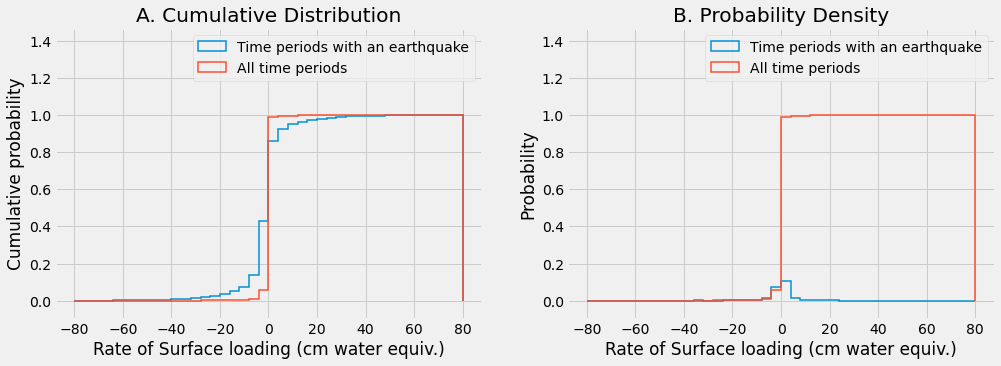

In [148]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
plt.style.use('fivethirtyeight')

plot_hist_rate(rate_alltime, rate_eq, ax1, ax2, 
              'A. Cumulative Distribution', 'B. Probability Density')

In [157]:
def plot_rel_hist_rate(all_time_periods, earthquake_only, ax, title):
    
    bins = np.linspace(-80,80,41)
    LgE = np.histogram(earthquake_only, bins=bins, density = True)[0]
    L   = np.histogram(all_time_periods,bins=bins, density = True)[0]

    wid = np.mean(np.diff(bins))
    ax.bar(bins[:-1]+wid/2,LgE/L,width=wid)

    ax.plot([-80,80],[1, 1],'--k')
    ax.text(-40, 2,'P=P(E)',color='k',fontsize=20)
    ax.set_xlabel('Rate of Surface Loading (cm water equiv.)',fontsize = 17)
    ax.set_ylabel('Relative Probability',fontsize = 17)
    ax.set_title(title, fontsize = 17)
    return fig,ax

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Relative Probability of Earthquake'}, xlabel='Rate of Surface Loading (cm water equiv.)', ylabel='Relative Probability'>)

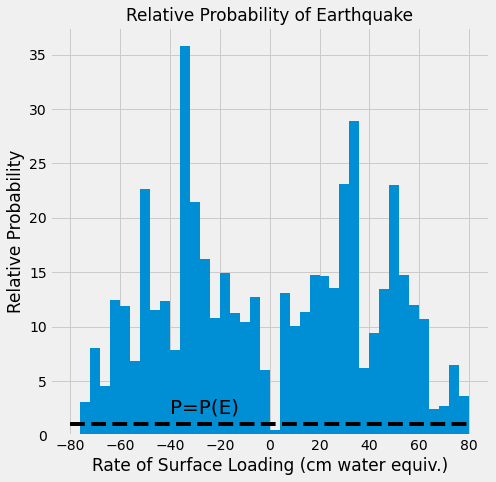

In [159]:
fig,ax = plt.subplots(figsize=(7,7))
plt.style.use('fivethirtyeight')
plot_rel_hist_rate(rate_alltime, rate_eq, ax, 'Relative Probability of Earthquake')